In [1]:
import seaborn as sns
import scipy
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from skimage import measure
from matplotlib.path import Path

from tools.localisation import nd_Id_cluster_loc_state

In [2]:
# Chargement des données
E = np.load('/home/smauran/Developpement/QG_standalone_counillon/save_mat/ens_149_ap_assim.npy')
print(E.shape)

N =29

(29, 16641)


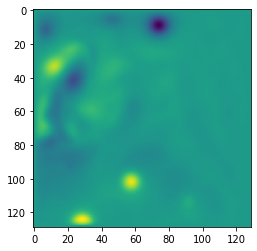

In [3]:
mean_ens = np.mean(E,axis=0)
Matmean=np.reshape(mean_ens,(129,129),order='F')
plt.imshow(Matmean)


In [4]:
from math import ceil

def get_clusters(E,loc,rad,taper,j,i):
    # clustering sur les variables
    N, Nx = E.shape
    #print(N,Nx) 
    
    
    dist_xx, state_taperer = loc(rad,taper)

    nblimit=5
    vec_bouldin=np.zeros((nblimit,1))

    for k in range(1,nblimit):
        nb=np.int64(k+1)
        kmeans = KMeans(n_clusters=nb, random_state=0, n_init = 'auto').fit(E.T)
        vec_bouldin[k]=davies_bouldin_score(E.T,kmeans.labels_)

    #tol = 5*10**-2

    ''' min_s=[]
    for k in range(2,nblimit):
        if abs(vec_bouldin[k]-vec_bouldin[nblimit-1]) <tol:
            min_s.append(k) '''
    #print(min_s) 

    #nb_min=min_s[0]
    nb_min=np.argmin(vec_bouldin[2:])+3
    #print("nb min", nb_min)

    kmeans = KMeans(n_clusters=nb_min, random_state=0, n_init = 'auto').fit(E.T)

    # 2me passe de clustering avec les contours
    
    labels = np.zeros(Nx)
    nb_clusters = 1

    # Clustering geometrique via detection de contours
    for c in range(nb_min):
        vec=np.zeros((i*j,1))
        # extraction des elements de la classe i
        inds = [index for (index,cluster) in enumerate(kmeans.labels_) if cluster == c]
        #dist_xx_ii = dist_xx[:,ind]
        #dist_xx_ii = dist_xx_ii[ind,:]

        vec[inds]=1
        Imclusk=np.reshape(vec,(j,i),order='F')


        # detection des contours fermes des classes
        contours = measure.find_contours(Imclusk,0)
        print('Nbre de contours pour la classe', np.int64(c),'=', len(contours))
        for num_contour in range(len(contours)):
                non_vide=False
                l_abs=[]
                l_ord=[]
                for ind in inds: # quels points du cluster sont dans le contour considéré ?
                    abs = ind%j
                    ord = ind//i
                    cluster_contour = np.array(contours[num_contour]).reshape(-1, 2)
                    path = Path(cluster_contour)
                    if path.contains_point((abs,ord)):
                            non_vide=True
                            l_abs.append(abs)
                            l_ord.append(ord)
                            labels[ind] = nb_clusters

                if non_vide:
                    inds_maj = [index for (index,cluster) in enumerate(labels) if cluster == nb_clusters]
                    abs_min = min(l_abs)
                    abs_max = max(l_abs)
                    ord_min = min(l_ord)
                    ord_max = max(l_ord)
                    # Idée pour les clusters trop petits : les mettre à -1 tant qu'on n'a pas trouvé le cluster vide, puis les rajouter au cluster vide
                    if len(inds_maj) < 0.001*i*j:
                        labels[inds_maj] = np.zeros(len(inds_maj))
                        

                    elif abs_max - abs_min > seuil or ord_max - ord_min > seuil :
                            dist_xx_ii = dist_xx[:,inds_maj]
                            dist_xx_ii = dist_xx_ii[inds_maj,:]
                            nc = int(ceil((abs_max - abs_min)/seuil)*ceil((ord_max - ord_min)/seuil))
                            kmeans_dist = KMeans(n_clusters=nc, random_state=0, n_init = 'auto').fit(dist_xx_ii)
                            labels[inds_maj] = nb_clusters*np.ones(len(inds_maj)) + kmeans_dist.labels_
                            nb_clusters += kmeans_dist.n_clusters
                    else:
                            nb_clusters += 1



    ## On s'occupe du contour "exterieur", label 0
    inds_0 = [index for (index,cluster) in enumerate(labels) if cluster == 0]
    l_abs_0=[]
    l_ord_0=[]
    for ind in inds_0:
        abs = ind%i
        ord = ind//j
        l_abs_0.append(abs)
        l_ord_0.append(ord)

    abs_min_0 = min(l_abs_0)
    abs_max_0 = max(l_abs_0)
    ord_min_0 = min(l_abs_0)
    ord_max_0 = max(l_abs_0)
    
    if abs_max_0 - abs_min_0 > seuil or ord_max_0 - ord_min_0 > seuil :

        dist_xx_ii = dist_xx[:,inds_0]
        dist_xx_ii = dist_xx_ii[inds_0,:]
        nc = int(ceil((abs_max_0 - abs_min_0)/seuil)*ceil((ord_max_0 - ord_min_0)/seuil))
        kmeans_dist = KMeans(n_clusters=nc, random_state=0, n_init = 'auto').fit(dist_xx_ii)
        
        labels[inds_0] = nb_clusters*np.ones(len(inds_0)) + kmeans_dist.labels_
        nb_clusters += kmeans_dist.n_clusters

    #print(davies_bouldin_score(E.T,labels))
    print("label max apres prise en compte des contours et redecoupage des gros clusters : ", nb_clusters)



    unique_labels = np.unique(labels)
    print("nb clusters reel", len(unique_labels))
    return(labels, nb_clusters, len(unique_labels),state_taperer)

In [18]:
''' 
def get_clusters(E,loc,rad,taper,j,i):
    # clustering sur les variables
    N, Nx = E.shape
    #print(N,Nx) 
    
    
    dist_xx, state_taperer = loc(rad,taper)

    nblimit=5
    vec_bouldin=np.zeros((nblimit,1))

    for k in range(1,nblimit):
        nb=np.int64(k+1)
        kmeans = KMeans(n_clusters=nb, random_state=0, n_init = 'auto').fit(E.T)
        vec_bouldin[k]=davies_bouldin_score(E.T,kmeans.labels_)

    #tol = 5*10**-2

    #min_s=[]
    #for k in range(2,nblimit):
        #if abs(vec_bouldin[k]-vec_bouldin[nblimit-1]) <tol:
            #min_s.append(k)
    #print(min_s) 

    #nb_min=min_s[0]
    nb_min=np.argmin(vec_bouldin[2:])+3
    #print("nb min", nb_min)

    kmeans = KMeans(n_clusters=nb_min, random_state=0, n_init = 'auto').fit(E.T)

    # 2ème passe de clustering avec les contours

    labels = np.zeros(Nx)
    nb_clusters = 1

    seuil = 40 # tester avec 25


    # Clustering géométrique via détection de contours
    for c in range(nb_min):
        vec=np.zeros((129*129,1))
        # extraction des éléments de la classe i
        inds = [index for (index,cluster) in enumerate(kmeans.labels_) if cluster == c]
        #dist_xx_ii = dist_xx[:,ind]
        #dist_xx_ii = dist_xx_ii[ind,:]

        vec[inds]=1
        Imclusk=np.reshape(vec,(129,129),order='F')


        # détection des contours fermés des classes
        contours = measure.find_contours(Imclusk,0)
        print('Nbre de contours pour la classe', np.int64(c),'=', len(contours))
        for num_contour in range(len(contours)):
                non_vide=False
                l_abs=[]
                l_ord=[]
                for ind in inds:
                    abs = ind%129
                    ord = ind//129
                    cluster_contour = np.array(contours[num_contour]).reshape(-1, 2)
                    path = Path(cluster_contour)
                    if path.contains_point((abs,ord)):
                            non_vide=True
                            l_abs.append(abs)
                            l_ord.append(ord)
                            labels[ind] = nb_clusters

                if non_vide:
                    inds_maj = [index for (index,cluster) in enumerate(labels) if cluster == nb_clusters]
                    abs_min = min(l_abs)
                    abs_max = max(l_abs)
                    ord_min = min(l_ord)
                    ord_max = max(l_ord)
                    if len(inds_maj) < 0.001*129*129:
                        labels[inds_maj] = np.zeros(len(inds_maj))
                        nb_clusters -= 1
                    elif abs_max - abs_min > seuil or ord_max - ord_min > seuil :
                            dist_xx_ii = dist_xx[:,inds_maj]
                            dist_xx_ii = dist_xx_ii[inds_maj,:]
                            nc = int(np.ceil((abs_max - abs_min)/seuil)*np.ceil((ord_max - ord_min)/seuil))
                            kmeans_dist = KMeans(n_clusters=nc, random_state=0, n_init = 'auto').fit(dist_xx_ii)
                            labels[inds_maj] = nb_clusters*np.ones(len(inds_maj)) + kmeans_dist.labels_
                            nb_clusters += kmeans_dist.n_clusters
                    else:
                            nb_clusters += 1

        # Affichage de la classe et des contours détectés
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.set_title('Image de la Classe' )
        ax2.set_title('Détection de contours géométriques')
        ax1.imshow(Imclusk)
        #plt.imsave("cluster_"+str(c)+".png",Imclusk)
        ax2.set_xlim([0,129])
        ax2.set_ylim([0,129])
        ax2.set_aspect('equal')
        for contour in contours:
                ax2.plot(contour[:, 1],129-contour[:, 0], linewidth=2)
        plt.show()





    ## On s'occupe du contour "extérieur", label 0

    inds_0 = [index for (index,cluster) in enumerate(labels) if cluster == 0]
    l_abs_0=[]
    l_ord_0=[]
    for ind in inds_0:
        abs = ind%129
        ord = ind//129
        l_abs_0.append(abs)
        l_ord_0.append(ord)

    abs_min_0 = min(l_abs_0)
    abs_max_0 = max(l_abs_0)
    ord_min_0 = min(l_abs_0)
    ord_max_0 = max(l_abs_0)
    if abs_max_0 - abs_min_0 > seuil or ord_max_0 - ord_min_0 > seuil :
        dist_xx_ii = dist_xx[:,inds_0]
        dist_xx_ii = dist_xx_ii[inds_0,:]
        nc = int(np.ceil((abs_max_0 - abs_min_0)/seuil)*np.ceil((ord_max_0 - ord_min_0)/seuil))
        kmeans_dist = KMeans(n_clusters=nc, random_state=0, n_init = 'auto').fit(dist_xx_ii)
        labels[inds_0] = nb_clusters*np.ones(len(inds_0)) + kmeans_dist.labels_
        nb_clusters += kmeans_dist.n_clusters

    #print(davies_bouldin_score(E.T,labels))
    print("label max après prise en compte des contours et redécoupage des gros clusters : ", nb_clusters)



    unique_labels = np.unique(labels)
    nb_clusters_reel = len(unique_labels)
    print("nb clusters réel", len(unique_labels))
    return(labels, nb_clusters, len(unique_labels),state_taperer) '''

In [7]:
i_dom = 129
j_dom = 129

shape=(i_dom,j_dom)
loc_state = nd_Id_cluster_loc_state(shape[::-1], periodic=False)
R_state = 3
taper='GC'
seuil = 20


labels,nb_clusters, nb_clusters_reel, state_taperer = get_clusters(E,loc_state,R_state,taper,j_dom,i_dom)


Nbre de contours pour la classe 0 = 5
Nbre de contours pour la classe 1 = 14
Nbre de contours pour la classe 2 = 9
Nbre de contours pour la classe 3 = 3
Nbre de contours pour la classe 4 = 11
label max apres prise en compte des contours et redecoupage des gros clusters :  90
nb clusters reel 89


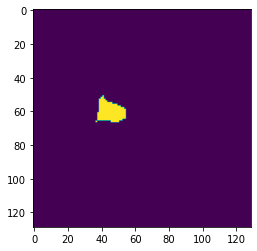

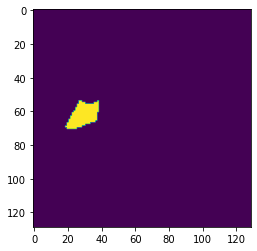

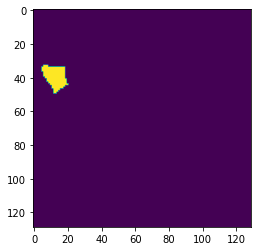

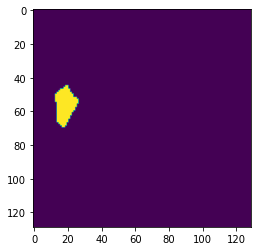

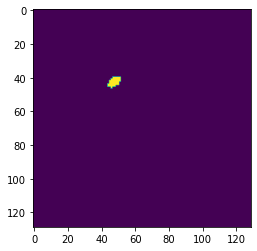

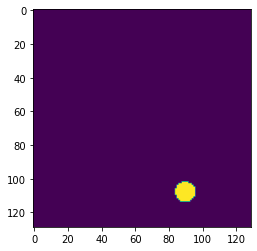

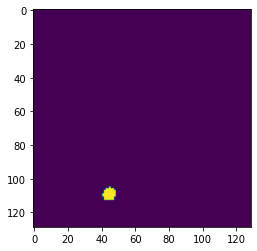

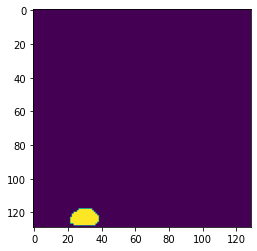

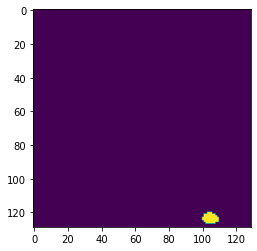

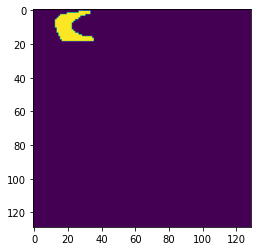

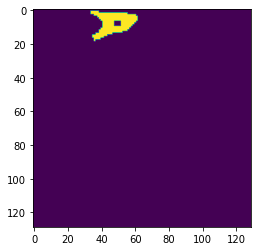

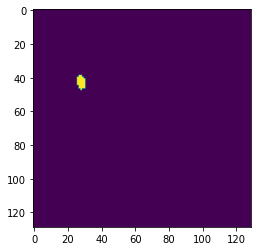

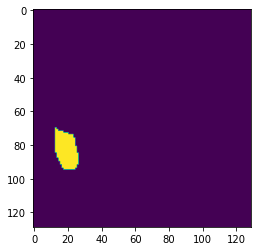

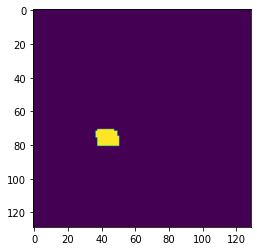

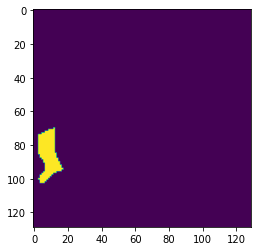

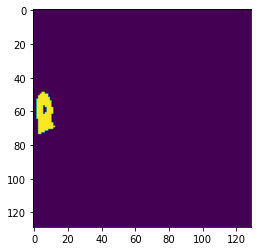

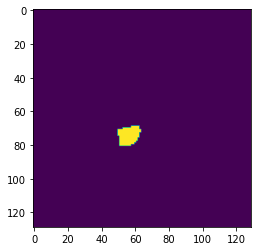

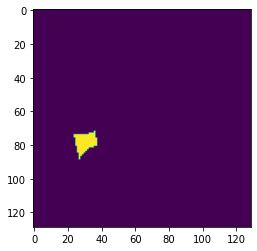

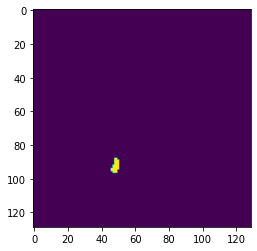

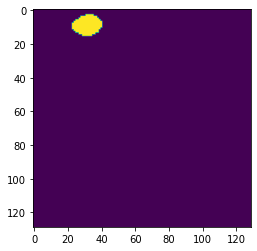

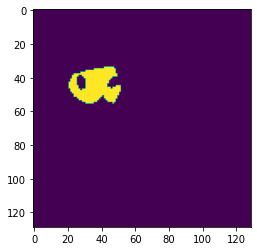

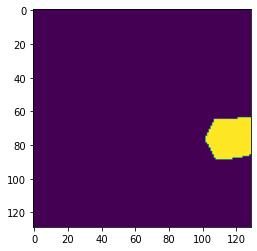

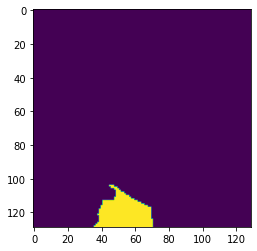

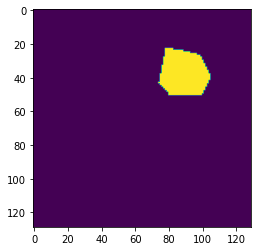

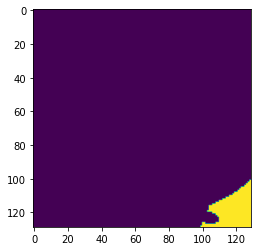

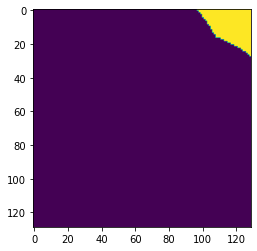

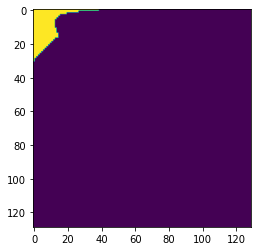

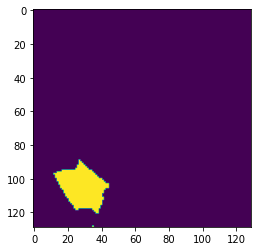

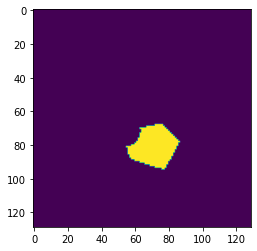

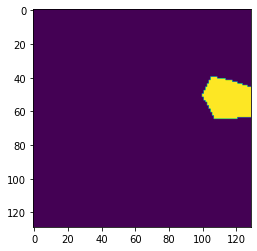

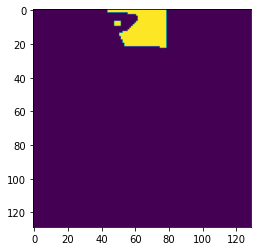

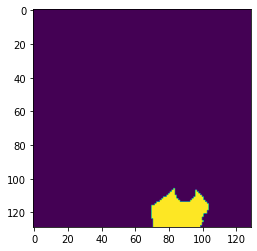

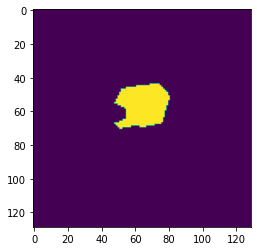

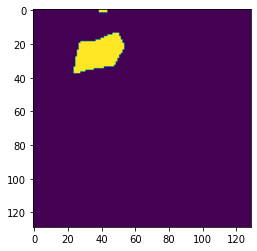

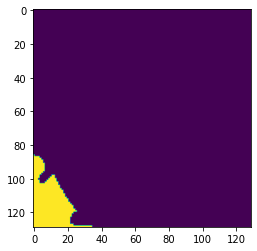

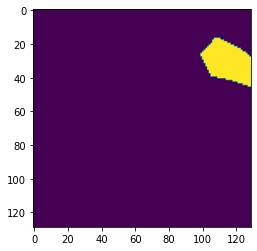

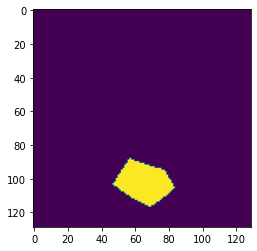

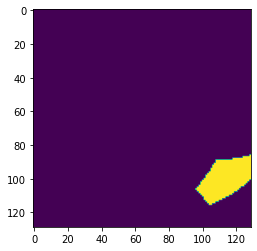

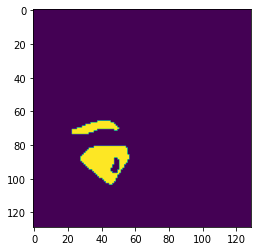

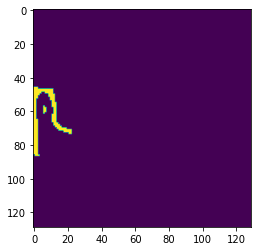

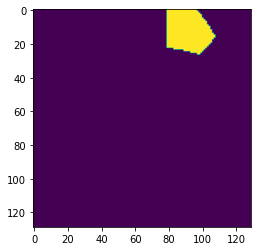

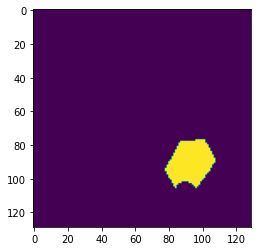

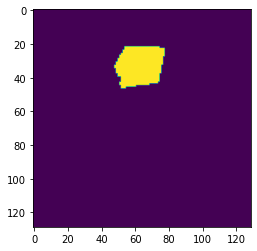

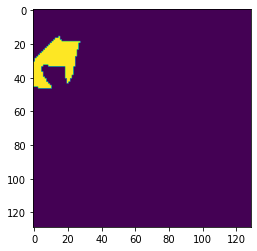

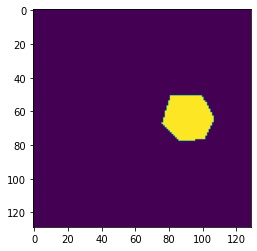

In [57]:
for i_cluster in range(nb_clusters):
    inds = [index for (index,cluster) in enumerate(labels) if cluster == i_cluster]
    if len(labels[inds]) != 0:
        vec=np.zeros((129*129,1))
        vec[inds]=1
        Imclusk=np.reshape(vec,(129,129),order='F')
        plt.imshow(Imclusk)
        plt.show()


label max après prise en compte des contours et redécoupage des gros clusters :  90
nb clusters réel 89


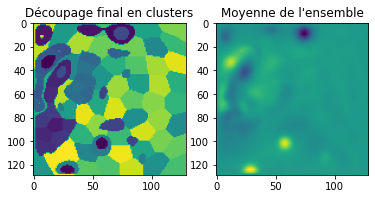

In [10]:
print("label max après prise en compte des contours et redécoupage des gros clusters : ", nb_clusters)

MatKM=np.reshape(labels,(129,129),order='F')
figure,(ax1,ax2) = plt.subplots(1,2)
ax1.imshow(MatKM)
plt.imsave("clusterF.png", MatKM)
ax1.set_title('Découpage final en clusters')
ax2.set_title('Moyenne de l\'ensemble')
ax2.imshow(Matmean)
unique_labels = np.unique(labels)
nb_clusters_reel = len(unique_labels)
print("nb clusters réel", len(unique_labels))


0
226


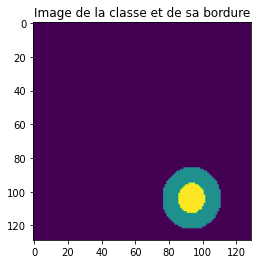

445


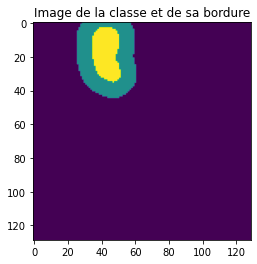

201


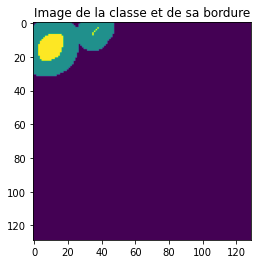

311


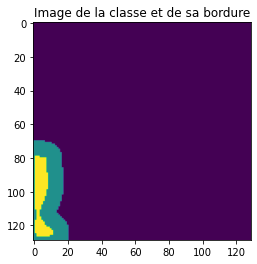

723


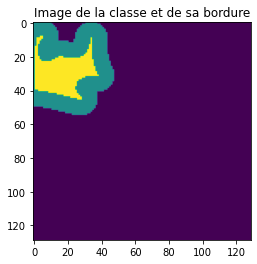

629


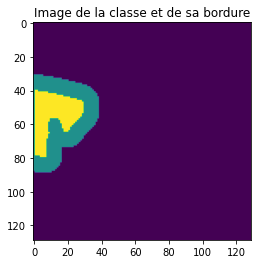

27


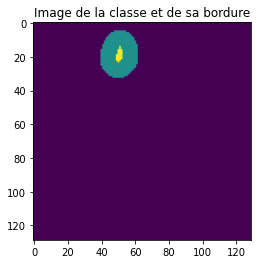

778


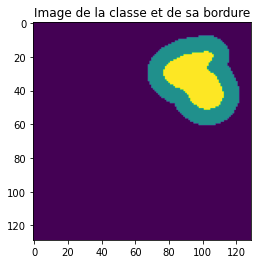

513


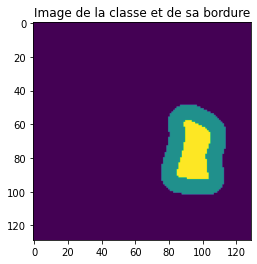

343


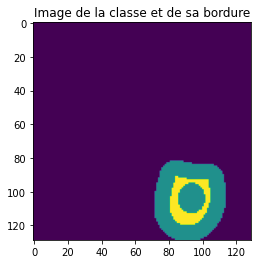

740


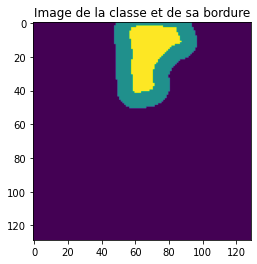

363


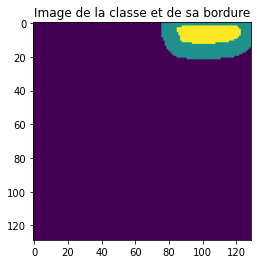

716


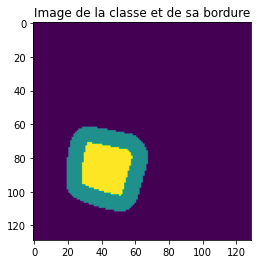

742


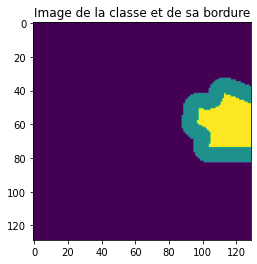

699


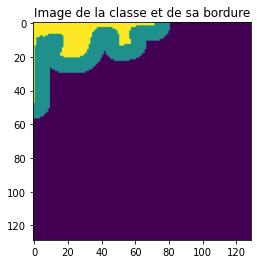

770


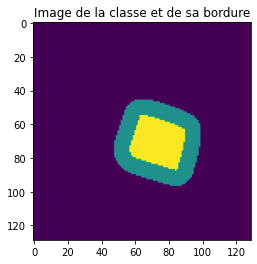

672


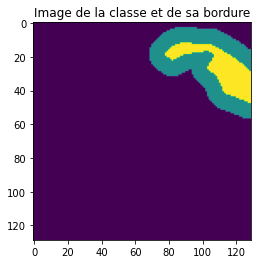

805


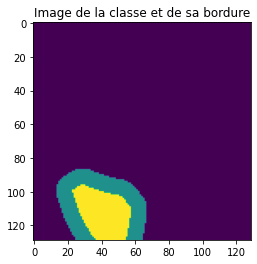

718


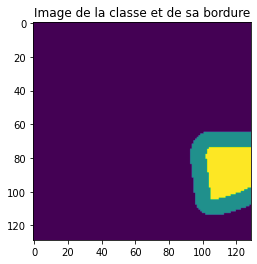

613


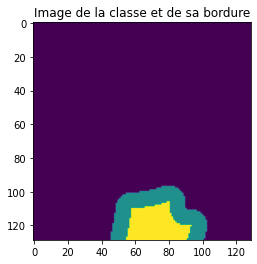

815


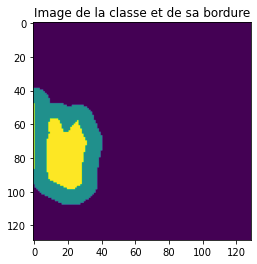

745


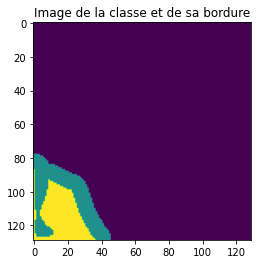

783


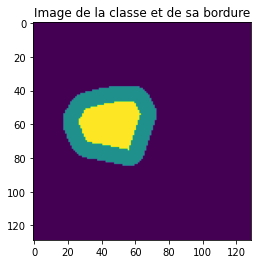

802


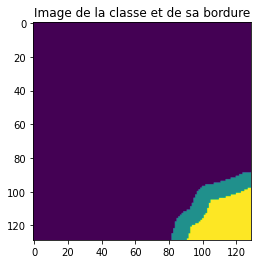

617


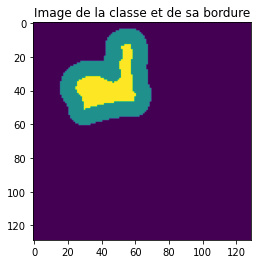

697


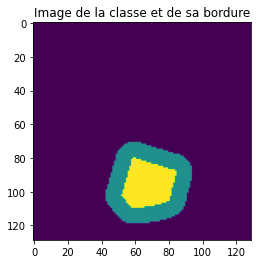

395


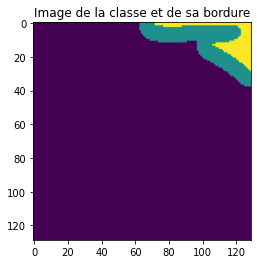

753


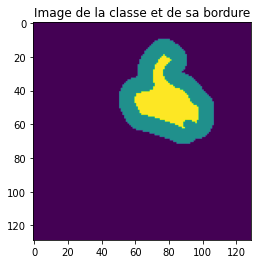

In [12]:
# Clustering géométrique via détection de contours
for i in range(nb_clusters):
  vec=np.zeros((129*129,1))
  # extraction des éléments de la classe i
  ind=np.where(labels==np.int64(i))
  print(len(ind[0]))
  if len(ind[0]) != 0:
    vec[ind]=1

    ind_tapered,_ = state_taperer(ind)
    vec[ind_tapered] += 1

    Imclusk=np.reshape(vec,(129,129),order='F')

    # Affichage de la classe et des contours détectés
    fig, ax = plt.subplots()
    ax.set_title('Image de la classe et de sa bordure' )
    ax.imshow(Imclusk)
    
    plt.show()
